# Predicting Tomorrow's Bitcoin Price

### Libraries : 

In [4]:
# Download the necessary libraries and functions 
import math
import pandas as pd
import numpy as np
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import datetime
import requests

# Set the plot style to ggplot
plt.style.use('ggplot')

### Overview of the Data

In [5]:
# Load the dataset 
data = pd.read_csv('./bitcoin_prices_train.csv')

In [6]:
# Show the shape of the dataset
data.shape

(1556, 7)

In [7]:
# Show the first entries of the dataset 
data.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [8]:
# Show the description of the dataset
data.describe()

,Open,High,Low,Close
count,1556.000000,1556.000000,1556.000000,1556.000000
mean,582.625328,597.992847,567.851446,584.239396
std,523.137312,542.992855,505.877401,525.904442
min,68.500000,74.560000,65.530000,68.430000
25%,254.287500,260.327500,248.835000,254.320000
50%,438.600000,447.560000,430.570000,438.855000
75%,662.437500,674.525000,646.735000,663.402500
max,2953.220000,2999.910000,2840.530000,2958.110000


/Users/herve/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


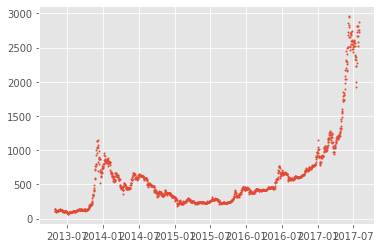

In [9]:
# Change the dates from strings to date 
data['Date'] = pd.to_datetime(data['Date'])

# Plot the closing price depending on the date 
plt.plot_date(x =data['Date'], y =data['Close'], markersize = 1)

As we can see the dataset contains the open price, the high price, the low price and the price at the closing of the Bitcoin for every days between April 28, 2013 and July 31, 2017

### Constants 

In [10]:
# Set the constant to the number of days we will use to predict the price of the Bitcoin
# In this case we consider the previous week to predict the price of the Bitcoin for the next day
previous_days_to_consider = 7

### Preprocess Data

In [11]:
# Function which prepares the data so that it is valid for the machine learning algorithms used afterward
# The preparation of the data is mostly replacing the "," by spaces and suppressing the date column
def process_df(df):
    df['Volume'] = df['Volume']\
        .str\
        .replace(',', '')\
        .replace({'-' : np.nan})\
        .astype('float64')
    df['Market Cap'] = df['Market Cap']\
        .str\
        .replace(',', '')\
        .astype('float64')
    df = df.drop('Date', axis=1)
    df = df.fillna(df.median())

    return df

In [12]:
# We apply our function to our dataframe so that our data is ready for the machine learning algorithms
data = process_df(data)

In [13]:
# Function which makes each row contain multiple days of data 
# This is because we want to base our prediction for the next day on data from multiple previous days.
def make_row_contain_multiple_days(df):
    x = []
    for i in range(len(df) - (previous_days_to_consider - 1)):
        x.append(
            pd.concat(
                [df.iloc[i + j].add_suffix('_' + str(j))
                 for j in range(previous_days_to_consider)]))
    x = pd.DataFrame(x)
    return x.fillna(x.median())

# Create a data set x where each row contains the data of the previous days that will be used as the training input
# Create a data set y that contains the price at close of the next day that will be used for the training cost function
def prepare_x_and_y(df):
    x = make_row_contain_multiple_days(df.iloc[1:])
    y = df.iloc[:-previous_days_to_consider]['Close']
    return x, y

In [14]:
# Use the most recent data to test our algorithms 
index_first_train_row = math.ceil(0.1 * len(data))

# Define x and y for our training data and our test data
X_train, y_train = prepare_x_and_y(data.iloc[index_first_train_row:])
X_test, y_test = prepare_x_and_y(data.iloc[:index_first_train_row])

In [15]:
# Check that the data type in each column are float 
data.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume        float64
Market Cap    float64
dtype: object

### Learning Pipeline

In [16]:
# Use pipeline to apply the scaler and the algorithms 
# We used the same scaler for each algorithm : Robust scaler

# The first pipeline apply MLPRegressor to the data 
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('regr', MLPRegressor())
])

# The second pipeline apply PassiveAggresiveRegressor to the data
pipe2 = Pipeline([
    ('scaler', RobustScaler()),
    ('regr', PassiveAggressiveRegressor())
])

# The third pipeline apply SGDRegressor to the data 
pipe3 = Pipeline([
    ('scaler', RobustScaler()),
    ('regr', SGDRegressor())
])

### Actual Learning

In [17]:
# Apply the first pipeline to the data and look at the R^2 score to estimate the accuracy 
pipe.fit(X_train,y_train)
r2_score(y_test, pipe.predict(X_test))

/Users/herve/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


-5.966363243958303

In [18]:
# Apply the second pipeline to the data and look at the R^2 score to estimate the accuracy 
pipe2.fit(X_train, y_train)
r2_score(y_test, pipe2.predict(X_test))

0.8780033591913996

In [19]:
# Apply the third pipeline to the data and look at the R^2 score to estimate the accuracy 
pipe3.fit(X_train,y_train)
r2_score(y_test, pipe3.predict(X_test))

0.9518161703894137

### Algorithms Comparison

In [20]:
# Set all the results in a vector 
results = [
    r2_score(y_test, pipe.predict(X_test)), 
    r2_score(y_test, pipe2.predict(X_test)), 
    r2_score(y_test, pipe3.predict(X_test))
]

In [21]:
# Set the names of all the algorithms in a vector 
algorithms_names = [
    'MLP Regression',
    'Passive Aggresive Regression',
    'SGD Regression'
]

algorithms = [1,2,3]

([<matplotlib.axis.XTick at 0x1a1c4fc450>,
 <a list of 3 Text xticklabel objects>)

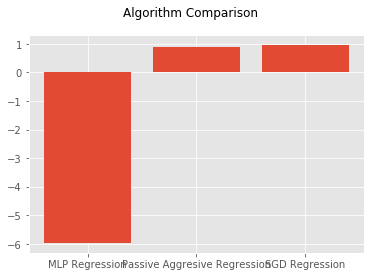

In [22]:
# Plot the efficency of the different algorithms in a bar plot 
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(algorithms, results)
plt.xticks(range(1,4), algorithms_names)

As the graph clearly shows, the passive aggresive regression and the SGD regression are much better than the MLP regression to predict the bitcoin's price given data from the previous week.

### Predicting Tomorrow Bitcoin's Price

In [23]:
# Find the date corresponding to yesterday
yesterday = datetime.datetime.today() - datetime.timedelta(days=1)

# Find the date corresponding to one week ago 
# In this case, as the close price for today does not exist yet we look at date 8 days ago 
one_week_ago = datetime.datetime.today() - datetime.timedelta(days= previous_days_to_consider + 1)
one_week_ago.isoformat(timespec='seconds')

'2020-12-10T15:05:27'

In [24]:
# Set the url for our API using the previously obtained dates 
url = f'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&time_start={one_week_ago.isoformat(timespec="seconds")}&time_end={yesterday.isoformat(timespec="seconds")}'

# Set the key to access the data through the API 
headers = {'X-CoinAPI-Key' : '33070FCA-7CEF-4F8D-9C33-518159F935F3'}

# Request the data through the API 
response = requests.get(url, headers=headers).json()

In [25]:
# Find the necessary data for the algorithms in the obtained JSON file 
json_to_df_mapping = {
    'price_open': 'Open',
    'price_high': 'High',
    'price_low': 'Low',
    'price_close': 'Close',
    'volume_traded': 'Volume',
}

# Set the data for the algorithms 
# As we couldnt obtain the market capitalization through an API, we set it manually 
data = {}
for index, day in enumerate(response):
    for json_key, df_column in json_to_df_mapping.items():
        data[df_column + '_' + str(index)] = day[json_key]
    data['Volume_' + str(index)]
    data['Market Cap_' + str(index)] = 420802394579
    
# Apply the PassiveAggresiveRegressor to predict tomorrow today's closing price of the Bitcoin
prediction = pipe2.predict(pd.DataFrame(data, index=[0]))

# Print the obtained result 
# We predicted the Bitcoin's price ! 
print('The price for the BitCoin at close today is predicted to be USD ' + str(round(prediction[0], 2)) + '.')

The price for the BitCoin at close today is predicted to be USD 18439.45.
